In [93]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

## Define the neural networks

In [94]:
class Encoder(nn.Module):
    def __init__(self, B=100, R=10):
        # B: number of spectral bands
        # R: size of the abundance vector z
        super(Encoder, self).__init__()

        self.layer_1 = nn.Linear(B, 9*R, bias=False)
        self.layer_2 = nn.Linear(9*R, 6*R, bias=False)
        self.layer_3 = nn.Linear(6*R, 3*R, bias=False)
        self.layer_4 = nn.Linear(3*R, R, bias=False)

        self.batch_norm = nn.BatchNorm1d(R)

        self.threshold = nn.Parameter(2 * (torch.rand(R)-0.5) / np.sqrt(R))

        self.leakyRelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()

    
    def forward(self, input):
        x = self.layer_1(input)
        x = self.leakyRelu(x)

        x = self.layer_2(x)
        x = self.leakyRelu(x)

        x = self.layer_3(x)
        x = self.leakyRelu(x)

        x = self.layer_4(x)
        x = self.leakyRelu(x)

        x = self.batch_norm(x)
        x = self.relu(x)

        # Soft thresholding for the non negativity constraint (ANC)
        x = x - self.threshold
        x = self.relu(x)

        # Normalize to make the sum equal to 1 (ASC)
        x = nn.functional.normalize(x, p=1.0, dim=1)

        return x

In [95]:
class Decoder(nn.Module):
    def __init__(self, B=100, R=10, init_endmembers=None, freeze=False):
        # B: number of spectral bands
        # R: size of the abundance vector z
        super(Decoder, self).__init__()

        if init_endmembers is not None:
            self.W = nn.Parameter(init_endmembers, requires_grad=not freeze)
        else:
            self.W = nn.Parameter(torch.abs(torch.rand(R, B)) / np.sqrt(R), requires_grad=not freeze)

    
    def forward(self, input):
        return input @ self.W
    
    def projection(self):
        # Projected gradient descent step
        #self.W[self.W <0] = 0#nn.Parameter(torch.clamp_min(self.W, min=torch.zeros(1)))
        #with torch.no_grad():
        #self.W = nn.Parameter(torch.clamp_min(self.W, min=torch.zeros(1)))
        
        with torch.no_grad():
            self.W[self.W<0] = 0

In [117]:
class AutoEncoder(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder  = decoder
    
    def forward(self, input):
        encoding = self.encoder(input)
        return encoding, self.decoder(encoding)
    
    def projection(self):
        self.decoder.projection()

In [118]:
class Discriminator(nn.Module):
    def __init__(self, B=100, R=10):
        # B: number of spectral bands
        # R: size of the abundance vector z
        super(Discriminator, self).__init__()

        n_hidden_1 = max(B // 4, R + 2) + 3
        n_hidden_2 = max(B // 10, R + 1)

        self.layer_1 = nn.Linear(R, n_hidden_1, bias=False)
        self.layer_2 = nn.Linear(n_hidden_1, n_hidden_2, bias=False)
        self.layer_3 = nn.Linear(n_hidden_2, 1, bias=False)

        self.relu = nn.ReLU()
        #self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.layer_1(input)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.relu(x)

        x = self.layer_3(x)
        #x = self.sigmoid(x)

        return x

In [98]:
class AAENet(nn.Module):
    
    def __init__(self, encoder, decoder, discrimator):
        super(AAENet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discrimator
    
    def forward(self, input):
        encoding = self.encoder(input)
        return encoding, self.decoder(encoding), self.discriminator(encoding)
    
    def projection(self):
        self.decoder.projection()
    
    def set_trainable_discriminator(self, trainable):
        for param in self.discriminator.parameters():
            param.requires_grad = trainable

In [99]:
a = torch.randn((2, 4))
b = torch.randn((2, 4))

nn.CosineSimilarity(dim=1)(a,b)

tensor([ 0.3554, -0.0693])

In [8]:
class AngleDistanceLoss(nn.Module):
    def __init__(self):
        super(AngleDistanceLoss, self).__init__()
        self.cos_sim = nn.CosineSimilarity(dim=1)

    def forward(self, x, y):
        angles = torch.arccos(self.cos_sim(x, y))
        return angles.mean()


## Generate synthetic data

In [8]:
N_pixels = 2000
B = 50 # Number of spectral bands
R = 2 # Number of endmembers

abundances = nn.functional.normalize(nn.functional.relu(torch.randn((N_pixels, R))))
abundances = nn.functional.normalize(nn.functional.relu(1 + 0.5*torch.randn((N_pixels, R))))
endmembers = torch.abs(torch.randn((R, B)))

data = abundances @ endmembers
print(data.shape)

torch.Size([2000, 50])


### Naive gradient descent

100%|██████████| 500/500 [00:05<00:00, 89.00it/s] 


Final loss 0.11423526


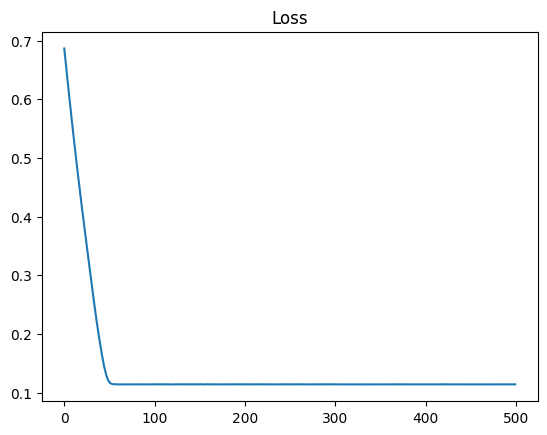

In [9]:
encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R)
ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-2, betas=(0.5, 0.9))

epochs = 500
losses = []

for e in tqdm(range(epochs)):
    opti.zero_grad()
    reconstruct = ae(data)
    #reconstruct = decoder(abundances)
    #loss = mse(reconstruct, data)
    loss = sad(reconstruct, data)
    loss.backward()
    opti.step()
    ae.projection()

    losses.append(loss.detach().numpy())

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

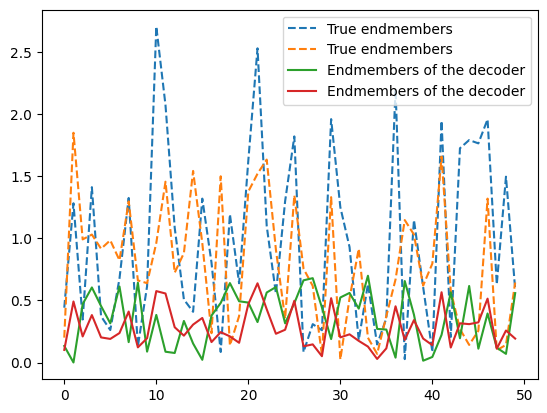

In [10]:
plt.plot(endmembers.numpy().T, label="True endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.legend()
plt.show()

### Alternate gradient descent (similar to PALM)

  1%|          | 4/500 [00:00<00:32, 15.22it/s]

100%|██████████| 500/500 [00:07<00:00, 63.77it/s]


Final loss 0.03875277


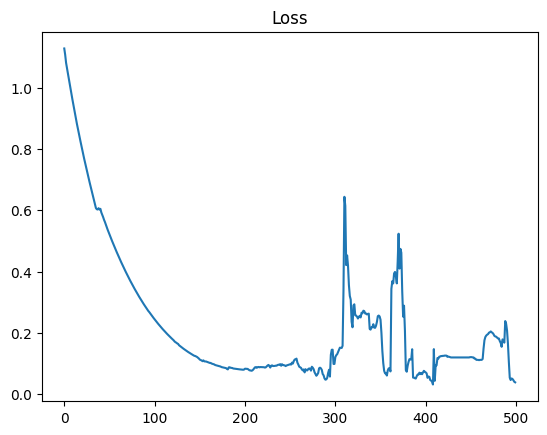

In [11]:
encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R)
ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
opti_encoder = torch.optim.Adam(encoder.parameters(), lr=1e-2, betas=(0.5, 0.9))
opti_decoder = torch.optim.Adam(decoder.parameters(), lr=1e-2, betas=(0.5, 0.9))

epochs = 500
losses = []

for e in tqdm(range(epochs)):
    opti_encoder.zero_grad()
    reconstruct = ae(data)
    loss = mse(reconstruct, data)
    loss.backward()
    opti_encoder.step()

    opti_decoder.zero_grad()
    reconstruct = ae(data)
    loss = mse(reconstruct, data)
    loss.backward()
    opti_decoder.step()
    ae.projection()

    losses.append(loss.detach().numpy())

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

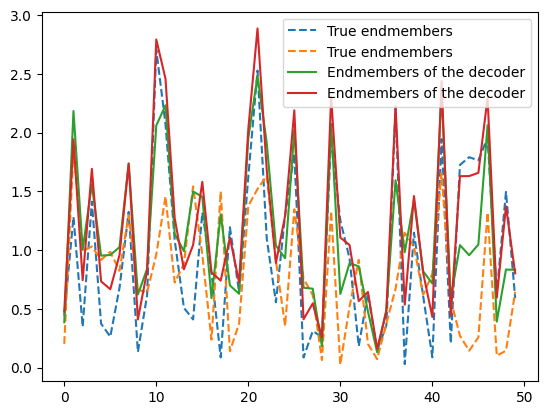

In [12]:
plt.plot(endmembers.numpy().T, label="True endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.legend()
plt.show()

In [13]:
decoder.projection()

In [14]:
torch.sum(decoder.W < 0)

tensor(0)

100%|██████████| 500/500 [00:04<00:00, 104.08it/s]


Final loss nan


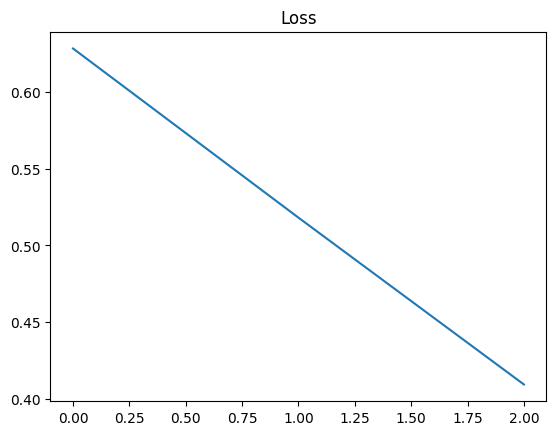

In [15]:
encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R)
decoder.W = nn.Parameter(endmembers)
ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(encoder.parameters(), lr=1e-2, betas=(0.5, 0.9))

epochs = 500
losses = []

for e in tqdm(range(epochs)):
    opti.zero_grad()
    reconstruct = ae(data)
    #reconstruct = decoder(abundances)
    #loss = mse(reconstruct, data)
    loss = sad(reconstruct, data)
    loss.backward()
    opti.step()
    ae.projection()

    losses.append(loss.detach().numpy())

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

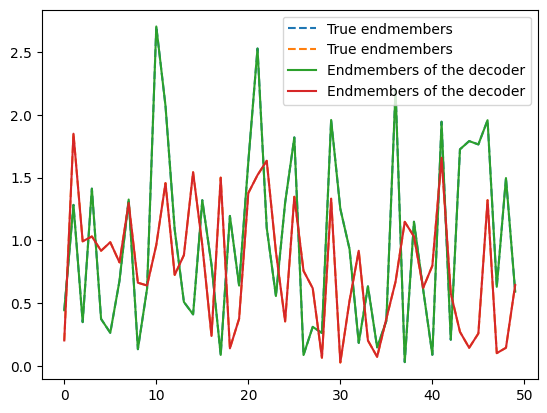

In [16]:
plt.plot(endmembers.numpy().T, label="True endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.legend()
plt.show()

## Real data

In [9]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
from munkres import Munkres
from scipy.io import loadmat

### Load and preprocess

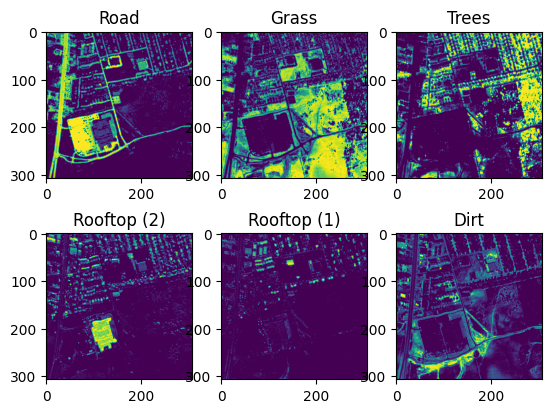

In [10]:
data = sci.loadmat('../data/urban/Urban.mat')
X = data['X']
X = X.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations
#X = X[::10, ::10]
X /= X.max()

gt = sci.loadmat('../data/urban/end6_groundTruth.mat')
abundances = gt['A']

nCol = 307
nRow = 307

plt.figure()
names = ['Road','Grass','Trees','Rooftop (2)','Rooftop (1)','Dirt']
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))
    
    plt.title(names[ii])


In [47]:
def MULecture(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1,A = -1, S = -1, frozenA=False):
    '''
    Inputs: 
    %           X: is a [mxn] matrix to unmig
    %
    %           r: size of the matrices A and S
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           A: is a [m x n] matrix 
    %           
    %           S: is a [n x t] matrix c
    %
  '''
    if r is None:
        r=X.shape[0]
    
    if frozenA:
        r = A.shape[1]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    if np.any(A < 0) and (not frozenA):
        A=np.random.random((d, r))
    if np.any(S < 0):
        S=np.random.random((r, N)) 
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # Multiplicative method      
        
        if not frozenA:
            A = A * (X @ S.T) / (A @ S @ S.T + eps) # Add a +eps in the denominator to avoid division by 0
        
        S = S * (A.T @ X) / (A.T @ A @ S + eps) # Add a +eps in the denominator to avoid division by 0

        # Convergence indices
        k = k + 1           
        diff=X-np.dot(A,S)     

        delta = np.linalg.norm(diff,'fro') / np.linalg.norm(X,'fro') 
        evolutionDelta.append(delta)
        
        if plot_evolution and (k==1 or k%100==0):
            print('Iteration NNMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', np.linalg.norm(diff))
     
    
    if plot_evolution==1:
        if k==N_Iter:
            print('Maximum number of iterations reached ! delta = ', delta)
        else:
            print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NNMF')
        plt.show()
    
    return A,S

In [12]:
def FCLS(pixels, endmembers): # Fully constrined least square (ref 44 of article)
    """
    Find abundances from the VCA endmemmbers

    pixels: (n_pixels, B)
    endmembers: (R, B)

    TODO: implement FCLS (now it is a basic linear regression)

    D. C. Heinz and C.-I. Chang, “Fully constrained least squares linear
    spectral mixture analysis method for material quantification in hyper-
    spectral imagery,” IEEE Trans. Geosci. Remote Sens., vol. 39, no. 3,
    pp. 529-545, Mar. 2001.
    """
    return torch.inverse(endmembers @ endmembers.T) @ endmembers @ pixels.T


In [13]:
def simpleVCA(X,r,optDisp=False):

    R = X.copy()
    
    
    K = np.zeros(r)
    
    for ii in range(r):
        c = np.random.rand(X.shape[0])
        ctX = c.T @ R
        
        p = np.argmax(ctX)
        K[ii] = p
        Rp = np.expand_dims(R[:,p],axis=1)
        
        if optDisp == True:
            fig = plt.figure()
            ax = fig.add_subplot(111,projection='3d')
            ax.scatter(R[0,:],R[1,:],R[2,:])
        
        R = R - (Rp@Rp.T /(np.sum(Rp.squeeze()**2)))@R
        
    print('Max residual %s'%np.max(R))
    
    return K.astype(int)

Max residual 0.1554167702168582


Text(0.5, 1.0, 'Estimation by VCA')

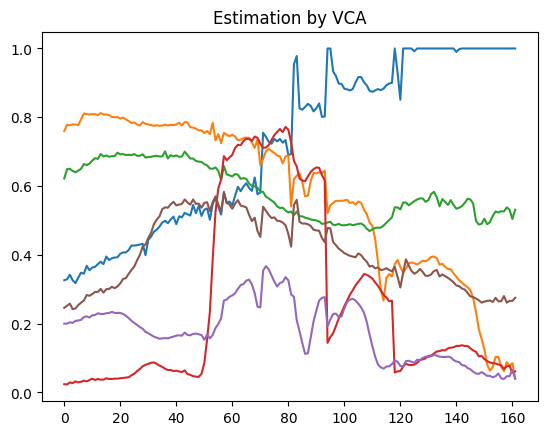

In [14]:
K_VCA = simpleVCA(X,6)

VCA_endmembers = X[:,K_VCA]

plt.figure(),plt.plot(VCA_endmembers)
plt.title('Estimation by VCA')

In [15]:
X.shape, VCA_endmembers.shape

((162, 94249), (162, 6))

kmeans clustering

In [16]:
X

array([[0.109, 0.116, 0.119, ..., 0.016, 0.012, 0.009],
       [0.113, 0.119, 0.119, ..., 0.019, 0.016, 0.013],
       [0.118, 0.13 , 0.127, ..., 0.028, 0.025, 0.023],
       ...,
       [0.259, 0.266, 0.289, ..., 0.077, 0.062, 0.047],
       [0.237, 0.256, 0.275, ..., 0.076, 0.066, 0.057],
       [0.264, 0.307, 0.275, ..., 0.061, 0.05 , 0.072]])

In [17]:
from sklearn.cluster import KMeans

K = 200
kmeans = KMeans(n_clusters=K, n_init=3)

kmeans.fit(X[:, ::5].T)


KMeans(n_clusters=200, n_init=3)

In [18]:
superpixels_indices = kmeans.predict(X.T)
print(superpixels_indices.shape)

(94249,)


In [19]:
batches = []
batch_size = 32


for k in range(K):
    pixel_indices = np.nonzero(superpixels_indices==k)[0]

    if pixel_indices.size >= 32:
        subsample = np.random.choice(pixel_indices.size, size=batch_size, replace=False)

        batches.append(torch.tensor(X[:, pixel_indices[subsample]].T, dtype=torch.float))

In [76]:
means = []
sqrt_covariances = []
eps = 1e-5
nb_none = 0

VCA_endmembers = torch.tensor(VCA_endmembers, requires_grad=False, dtype=torch.float)
for batch in tqdm(batches):
    #abundances = FCLS(batch, VCA_endmembers.T).T
    abundances = MULecture(batch.detach().numpy().T, A=VCA_endmembers.detach().numpy(), frozenA=True, plot_evolution=False)[1]
    abundances = torch.tensor(abundances, dtype=torch.float)
    mean = abundances.mean(axis=1)
    means.append(mean)

    centered_abundances = (abundances.T - mean).T
    cov = centered_abundances @ centered_abundances.T
    sqrt = torch.linalg.cholesky(cov + torch.eye(len(mean))*eps).T

    sqrt_covariances.append(sqrt)


C:\Users\matth\AppData\Local\Temp\ipykernel_21228\3419189309.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  VCA_endmembers = torch.tensor(VCA_endmembers, requires_grad=False, dtype=torch.float)
100%|██████████| 193/193 [00:14<00:00, 13.51it/s]


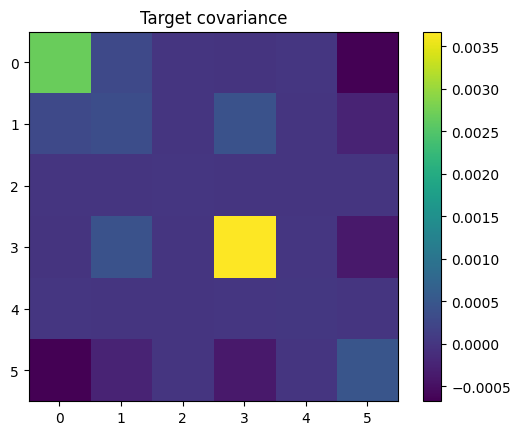

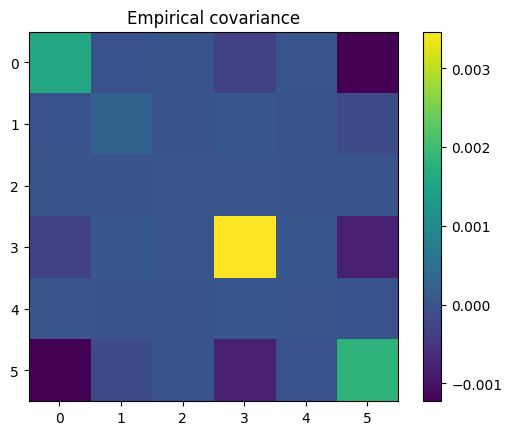

In [83]:
sqrt = sqrt_covariances[np.random.randint(0, len(sqrt_covariances))]
plt.imshow((sqrt @ sqrt.T).detach().numpy())
plt.title("Target covariance")
plt.colorbar()
plt.show()

noise = np.random.randn(1000, 6)
samples = noise @ sqrt.detach().numpy()
empirical_cov = (samples.T @ samples)/1000
plt.imshow(empirical_cov)
plt.title("Empirical covariance")
plt.colorbar()
plt.show()

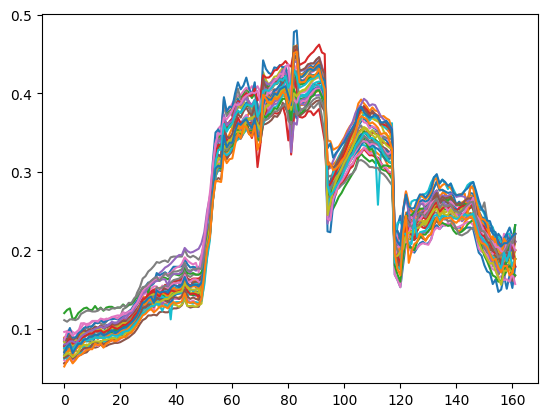

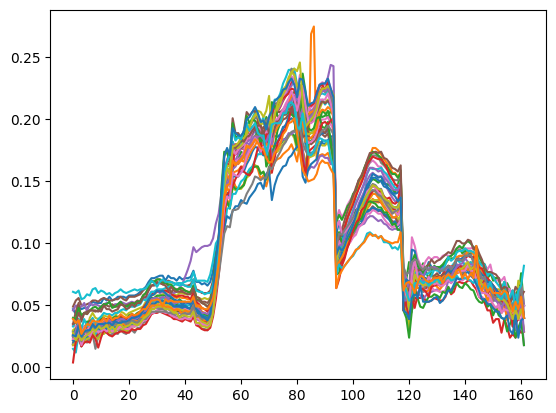

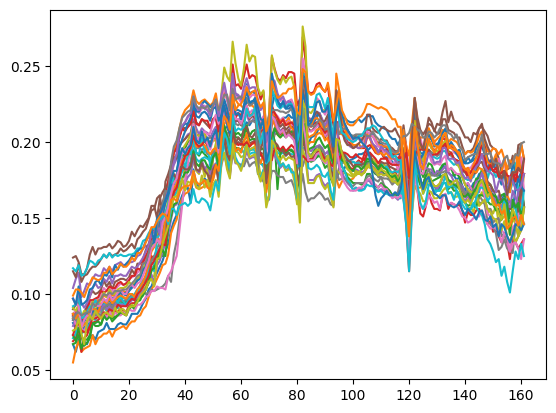

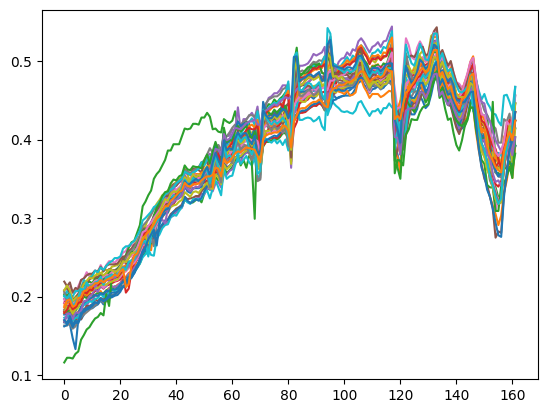

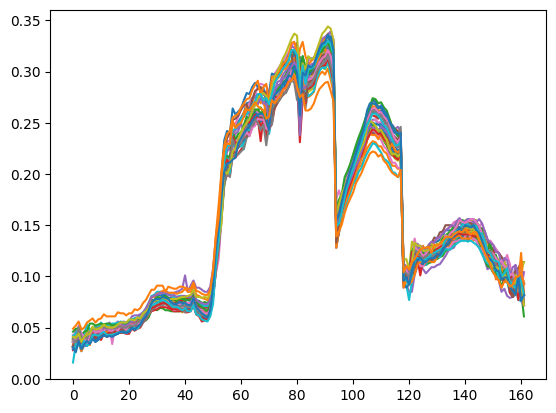

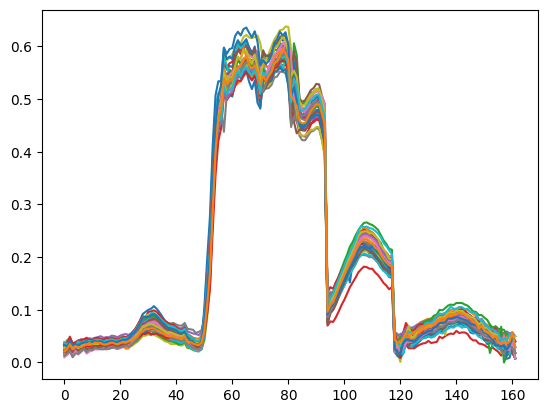

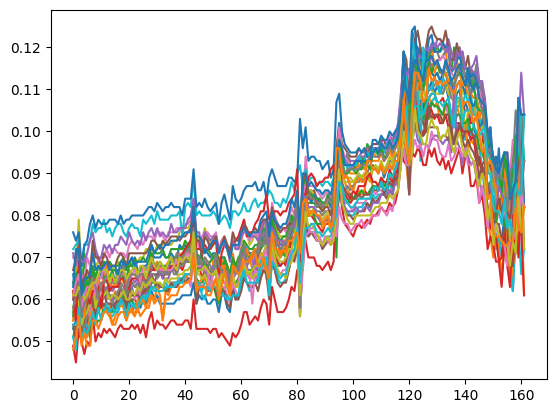

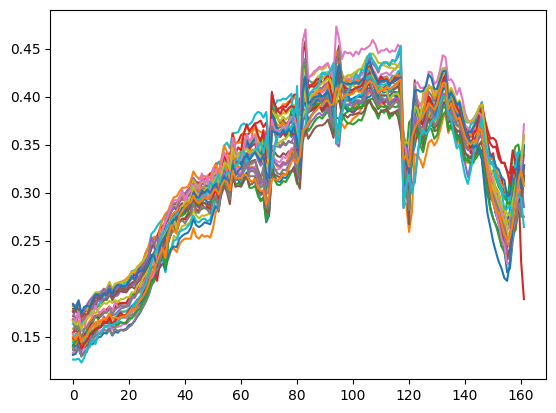

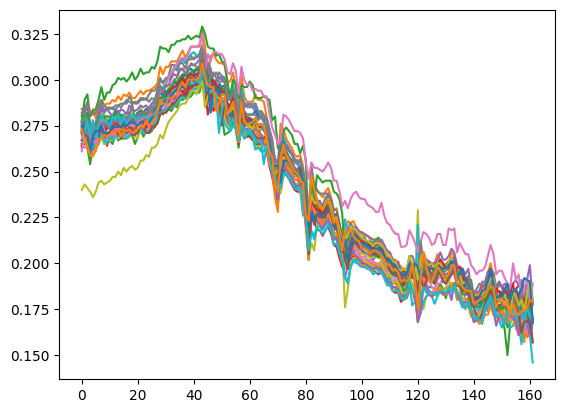

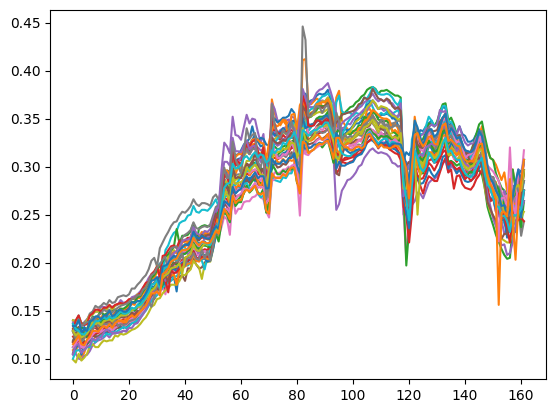

In [84]:
for i in range(10):
    plt.plot(batches[i].detach().numpy().T)
    plt.show()

## Train the AAENet without adversarial regularization

### Random decoder initialization

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]

Final loss 0.09905133


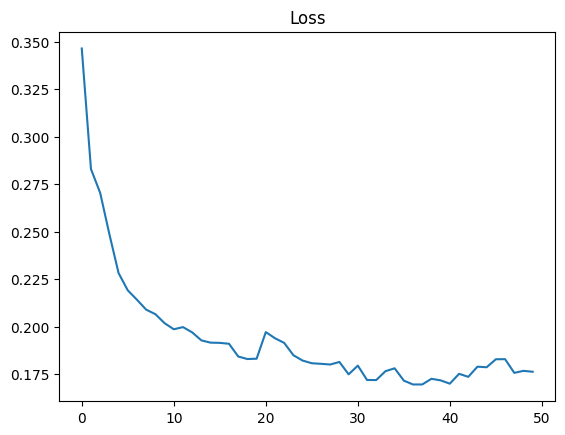

In [46]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R)
ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.5, 0.9))

epochs = 50
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()
        reconstruct = ae(batches[b])
        #reconstruct = decoder(abundances)
        loss = sad(reconstruct, batches[b])
        loss.backward()
        opti.step()
        ae.projection()
        loss_epoch += loss.detach().numpy()

    losses.append(loss_epoch / len(batches))

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

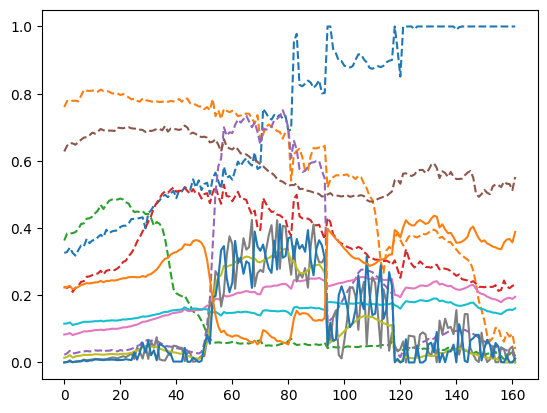

In [47]:
plt.plot(VCA_endmembers, label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
#plt.legend()
plt.show()

### Using VCA as initialization for decoder

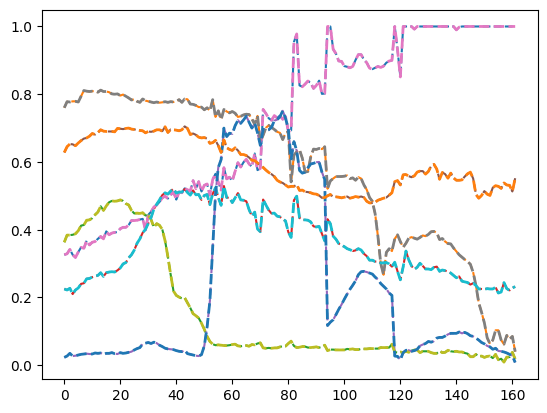

100%|██████████| 50/50 [00:28<00:00,  1.77it/s]

Final loss 0.08597009


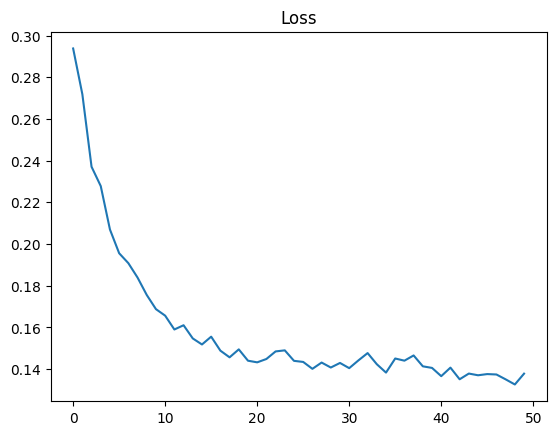

In [48]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float))

ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

plt.plot(VCA_endmembers, label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.show()

epochs = 50
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()
        reconstruct = ae(batches[b])
        #reconstruct = decoder(abundances)
        loss = sad(reconstruct, batches[b])
        loss.backward()
        opti.step()
        ae.projection()
        opti.zero_grad()
        loss_epoch += loss.detach().numpy()

    losses.append(loss_epoch / len(batches))
    #print("Decoder variation", np.linalg.norm(decoder.W.detach().numpy() - VCA_endmembers.T))

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

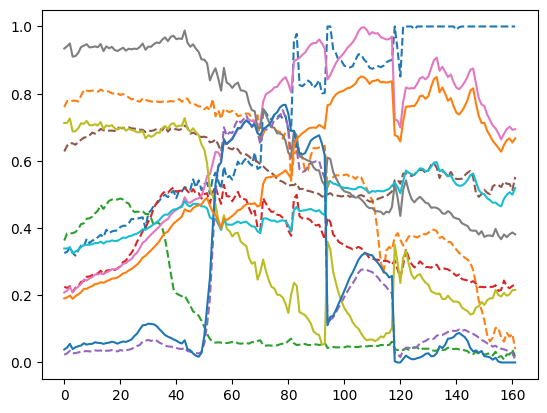

In [49]:
plt.plot(VCA_endmembers, label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.show()

### Initialize with VCA and freeze decoder

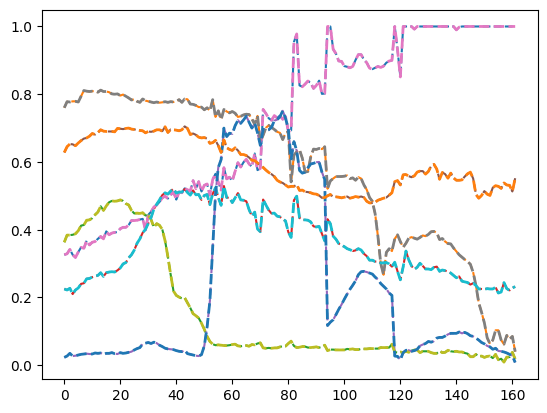

100%|██████████| 50/50 [00:23<00:00,  2.10it/s]

Final loss 0.147084


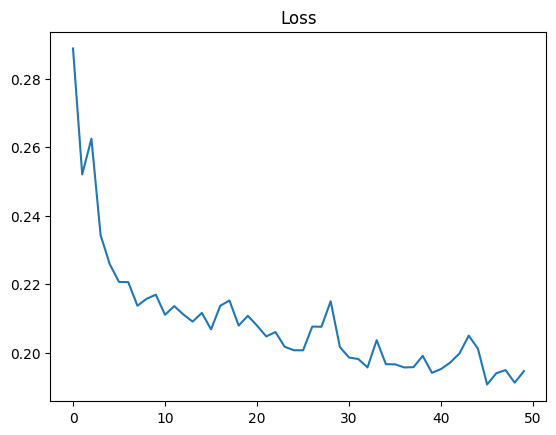

In [50]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float), freeze=True)

ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

plt.plot(VCA_endmembers, label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.show()

epochs = 50
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()
        reconstruct = ae(batches[b])
        #reconstruct = decoder(abundances)
        loss = sad(reconstruct, batches[b])
        loss.backward()
        opti.step()
        ae.projection()
        opti.zero_grad()
        loss_epoch += loss.detach().numpy()

    losses.append(loss_epoch / len(batches))
    #print("Decoder variation", np.linalg.norm(decoder.W.detach().numpy() - VCA_endmembers.T))

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

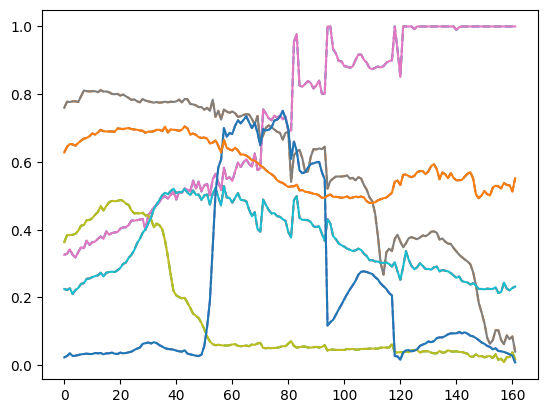

In [51]:
plt.plot(VCA_endmembers, label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.show()

## Train with adversarial regularization


TO DO : 
- debug autograd
- debug nan
- check generation of fake samples using VCA
- record discriminator loss
- add regularization term in AE loss (cf equation 19)

### Train only the autoencoder with a fixed discriminator

C:\Users\matth\AppData\Local\Temp\ipykernel_21228\3103776642.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float), freeze=False)


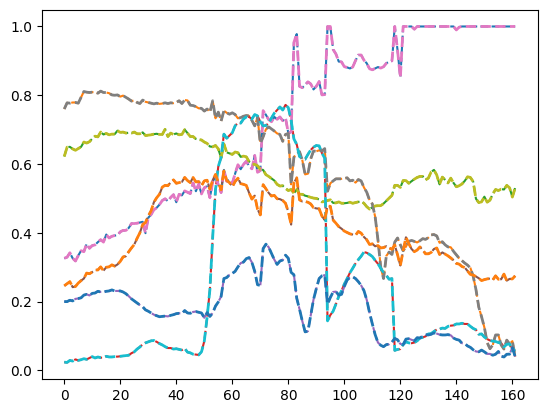

100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

Final loss -243.24579


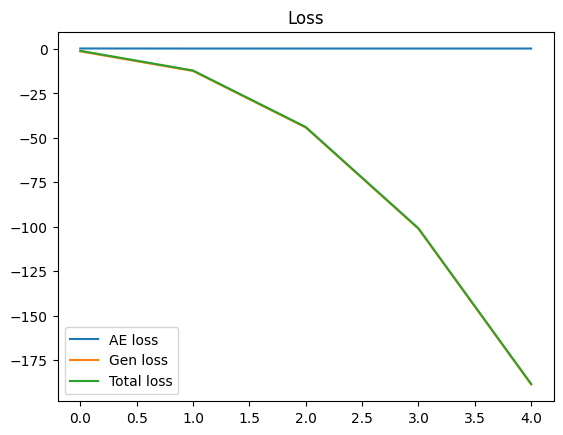

In [107]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float), freeze=False)
discriminator = Discriminator(B=B, R=R)

aaenet = AAENet(encoder, decoder, discriminator)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
bceLogits = nn.BCEWithLogitsLoss()

# Optimizer for autoencoder
opti = torch.optim.Adam(aaenet.parameters(), lr=1e-3, betas=(0.9, 0.99))

# Optimizer for discriminator
opti_D = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.9, 0.99))

plt.plot(VCA_endmembers.detach().numpy(), label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.show()

epochs = 5
losses_AE = []
losses_G = []
losses = []


for e in tqdm(range(epochs)):
    loss_AE_epoch = 0
    loss_G_epoch = 0
    loss_epoch = 0
    for b in range(len(batches)):

        # Train the reconstruction
        opti.zero_grad()
        neg_samples, reconstruct, pred = aaenet(batches[b])
        if neg_samples.isnan().any():
            print(e, b, "nan neg_samples")
            break
        if reconstruct.isnan().any():
            print(e, b, "nan reconstruct")
            break
        if pred.isnan().any():
            print(e, b, "nan pred")
            break

        loss_AE = sad(reconstruct, batches[b]) # Reconstruction error
        loss_G = -bceLogits(pred, torch.zeros((batch_size, 1), dtype=torch.float)) #torch.mean(torch.log(1 - pred).reshape(-1))
        #loss_G = torch.mean(torch.log(torch.exp(-pred) / (1 + torch.exp(-pred))).reshape(-1))

        loss = loss_AE + loss_G
        if loss.isnan().any():
            print(e, b, "nan loss")
            break
        loss.backward() 
        for name, param in aaenet.named_parameters():
            if param.grad.isnan().any():
                print(e, b, "nan grad", name)
                print(pred)

        opti.step()
        ae.projection()
        loss_AE_epoch += loss_AE.detach().numpy()
        loss_G_epoch += loss_G.detach().numpy()
        loss_epoch += loss.detach().numpy()
        

    losses_AE.append(loss_AE_epoch / len(batches))
    losses_G.append(loss_G_epoch / len(batches))
    losses.append(loss_epoch / len(batches))


print("Final loss", loss.detach().numpy())
plt.plot(losses_AE, label="AE loss")
plt.plot(losses_G, label="Gen loss")
plt.plot(losses, label="Total loss")
plt.legend()
#plt.yscale('log')
plt.title("Loss")
plt.show()

### Train only the discriminator

C:\Users\matth\AppData\Local\Temp\ipykernel_21228\3423945168.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float), freeze=False)


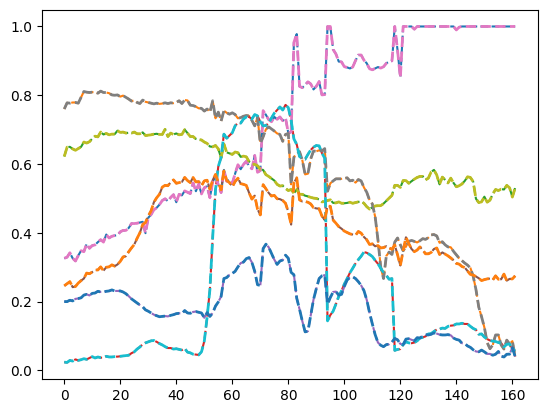

100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

Final loss -244.14334


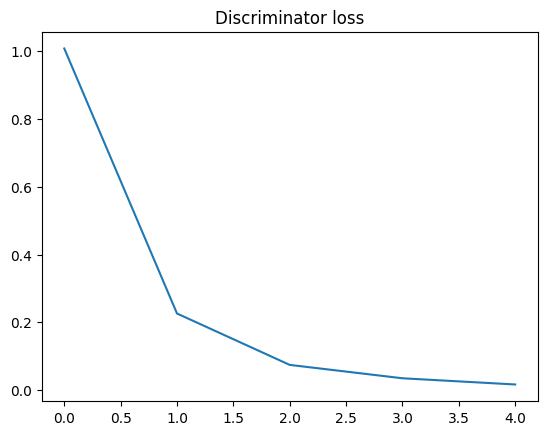

In [115]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float), freeze=False)
discriminator = Discriminator(B=B, R=R)

ae = AAENet(encoder, decoder, discriminator)

mse = nn.MSELoss()
sad = AngleDistanceLoss()

# Optimizer for autoencoder
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

# Optimizer for discriminator
opti_D = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.9, 0.99))

plt.plot(VCA_endmembers.detach().numpy(), label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.show()

epochs = 5
losses_AE = []
losses_G = []
losses = []
losses_D = []


for e in tqdm(range(epochs)):
    loss_AE_epoch = 0
    loss_G_epoch = 0
    loss_epoch = 0
    loss_D_epoch = 0
    for b in range(len(batches)):

        # Train the reconstruction
        opti.zero_grad()
        neg_samples, reconstruct, pred = aaenet(batches[b])
        if neg_samples.isnan().any():
            print(e, b, "nan neg_samples")
            break

        if reconstruct.isnan().any():
            print(e, b, "nan reconstruct")
            break

        if pred.isnan().any():
            print(e, b, "nan pred")
            break
        """
        loss_AE = sad(reconstruct, batches[b]) # Reconstruction error
        loss_G = -bceLogits(pred, torch.zeros((batch_size, 1), dtype=torch.float)) #torch.mean(torch.log(1 - pred).reshape(-1))
        #loss_G = torch.mean(torch.log(torch.exp(-pred) / (1 + torch.exp(-pred))).reshape(-1))

        loss = loss_AE + loss_G
        if loss.isnan().any():
            print(e, b, "nan loss")
            break

        loss.backward() 
        for name, param in aaenet.named_parameters():
            if param.grad.isnan().any():
                print(e, b, "nan grad", name)
                print(pred)

        opti.step()
        ae.projection()
        opti.zero_grad()
        loss_AE_epoch += loss_AE.detach().numpy()
        loss_G_epoch += loss_G.detach().numpy()
        loss_epoch += loss.detach().numpy()
        """

        # Train the discriminator
        # To be based on equation 8:
        opti_D.zero_grad()
        
        # Generate positive samples:
        pos_samples = means[b] + torch.randn(batch_size, R) @ sqrt_covariances[b].T 
        pos_pred = discriminator(pos_samples)
        neg_pred = discriminator(neg_samples)

        #loss_D = - torch.mean(torch.log(pos_pred)) - torch.mean(torch.log(1 - neg_pred)) # eq. 8
        loss_D_pos = bceLogits(pos_pred, torch.ones((batch_size, 1), dtype=torch.float)) 
        loss_D_neg = bceLogits(neg_pred, torch.zeros((batch_size, 1), dtype=torch.float))
        loss_D = loss_D_pos + loss_D_neg
        loss_D.backward()
        opti_D.step()
        #opti_D.zero_grad()
        loss_D_epoch += loss_D.detach().numpy()
        
        
    losses_D.append(loss_D_epoch / len(batches))




print("Final loss", loss.detach().numpy())
plt.plot(losses_D)
#plt.yscale('log')
plt.title("Discriminator loss")
plt.show()

### Train both alternately

C:\Users\matth\AppData\Local\Temp\ipykernel_21228\3272835564.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float), freeze=False)


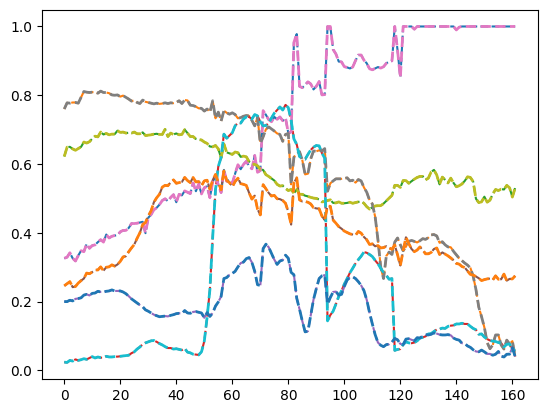

  0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [123]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float), freeze=False)
discriminator = Discriminator(B=B, R=R)

ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()

# Optimizer for autoencoder
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

# Optimizer for discriminator
opti_D = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.9, 0.99))

plt.plot(VCA_endmembers.detach().numpy(), label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.show()

epochs = 5
losses_AE = []
losses_G = []
losses = []
losses_D = []


for e in tqdm(range(epochs)):
    weight_gen = 1 - np.exp(-0.1-0.1*e**2)
    loss_AE_epoch = 0
    loss_G_epoch = 0
    loss_epoch = 0
    loss_D_epoch = 0
    for b in range(len(batches)):

        # Train the reconstruction
        opti.zero_grad()
        encoding, reconstruct = ae(batches[b])
        if encoding.isnan().any():
            print(e, b, "nan neg_samples")
            break

        if reconstruct.isnan().any():
            print(e, b, "nan reconstruct")
            break

        loss_AE = sad(reconstruct, batches[b]) # Reconstruction error
        loss_G = -bceLogits(pred, torch.zeros((batch_size, 1), dtype=torch.float)) #torch.mean(torch.log(1 - pred).reshape(-1))
        #loss_G = torch.mean(torch.log(torch.exp(-pred) / (1 + torch.exp(-pred))).reshape(-1))

        loss = loss_AE + loss_G * weight_gen
        if loss.isnan().any():
            print(e, b, "nan loss")
            break

        loss.backward() 
        for name, param in aaenet.named_parameters():
            if param.grad.isnan().any():
                print(e, b, "nan grad", name)
                print(pred)

        opti.step()
        ae.projection()
        opti.zero_grad()
        loss_AE_epoch += loss_AE.detach().numpy()
        loss_G_epoch += loss_G.detach().numpy()
        loss_epoch += loss.detach().numpy()

        
        
        # Train the discriminator
        # To be based on equation 8:
        opti_D.zero_grad()
        
        # Generate positive samples:
        pos_samples = means[b] + torch.randn(batch_size, R) @ sqrt_covariances[b].T 
        pos_pred = discriminator(pos_samples)
        neg_pred = discriminator(encoding.detach())

        #loss_D = - torch.mean(torch.log(pos_pred)) - torch.mean(torch.log(1 - neg_pred)) # eq. 8
        loss_D_pos = bceLogits(pos_pred, torch.ones((batch_size, 1), dtype=torch.float)) 
        loss_D_neg = bceLogits(neg_pred, torch.zeros((batch_size, 1), dtype=torch.float))
        loss_D = loss_D_pos + loss_D_neg
        loss_D.backward()
        opti_D.step()
        #opti_D.zero_grad()
        loss_D_epoch += loss_D.detach().numpy()

        

    losses_D.append(loss_D_epoch / len(batches))
    losses_AE.append(loss_AE_epoch / len(batches))
    losses.append(loss_epoch / len(batches))
    losses_G.append(loss_G_epoch / len(batches))




print("Final loss", loss.detach().numpy())
plt.plot(losses_D)
#plt.yscale('log')
plt.title("Discriminator loss")
plt.show()